# Artem Moskalev. Home Assignment -- 5

# Part 1 (19 pt.): Model selection and sensitivity analysis

## Task 1 (2 pt.): Information criteria

Assume that regression model is
$$y = \sum_{i=1}^k \beta_i x_i + \varepsilon,$$
and $\varepsilon$ is dictributed as normally: $\varepsilon \sim \mathcal{N}(0, \sigma^2)$, $\sigma^2$ is known.

Prove that the model with highest Akaike information criterion is the model with smallest Mallow's $C_p$.

**BEGIN Solution**

From lectures:

$AIC = k\ln(\frac 1 {\sqrt{2\pi}\sigma}) - \frac 1 {2\sigma^2} \sum_{i=1}^k(y_i - f(\beta_J;x_{i,J}))^2 - |J|$

$C_p = \frac 1 k \sum_{i=1}^k(y_i - f(\beta_J;x_{i,J}))^2 + 2 \frac {\sigma^2} k |J|$

As we are comparing an estimation of these criterions for the same model, we can get rid of all constants: 

$AIC^{'} = - \sum_{i=1}^k(y_i - f(\beta_J;x_{i,J}))^2 - |J|$

$C_p^{'} = \sum_{i=1}^k(y_i - f(\beta_J;x_{i,J}))^2 + |J|$ 

From here we can vividly see that $\max_{|J|} AIC = \min_{|J|} C_p$

**END Solution**

<br/> <!--Intentionally left blank-->

## Task 2 (17 pt.): Sensitivity analysis and optimization for rotating disk problem

In this tsk, you are proposed to solve a problem of optimization of a rotating disc. You will use approximation techniques, sensitivity analysis and optimization. For sensitivity analysis you are recommended to use SALib library (https://github.com/SALib/SALib), and scipy for optimization.

1. Parameters `r1,t1,r2,r3,t3,r4` are input variables that define a geometrical shape of a disk. Parameters `mass,smax,u2` are mass of a disk, maximal radial stress, and contact stress, respectively. **Those are the
target variables to predict (yes there are three regression targets).**
2. The `problem` Pythonic dict is used for SALib methods and defines bounds for parameters.

### Necessary imports

Run the following command in the next empty code cell.

```python
!pip install salib
```

Other imports

In [1]:
%matplotlib inline
from SALib.analyze import sobol as sobol_analyzer
from SALib.analyze import morris as morris_analyzer

from SALib.sample import saltelli as saltelli_sampler
from SALib.sample import morris as morris_sampler

from scipy.optimize import minimize

import numpy as np
import pandas as pd

from matplotlib import pyplot

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

### Define problem

Problem is defined as a simple Pythonic dict, where you should number of input variables,
bounds for each input variable and their names. This will be helpful for sensitivity analysis.
Note, that bounds defined here are true for **standardized data**.

In [2]:
data = pd.read_csv('data/doe_100.csv')

problem = {
    'num_vars': 6,
    'names': data.columns.values[:6],
    'bounds': np.array([[-1.7321, 1.7321],
                        [-1.7321, 1.7321],
                        [-1.7321, 1.7321],
                        [-1.7321, 1.7321],
                        [-1.7321, 1.7321],
                        [-1.7321, 1.7321]]),
    'groups': None
    }

In [3]:
sscaler = StandardScaler()

X = pd.DataFrame(sscaler.fit_transform(data[problem['names']].copy()), columns=problem['names'])
y = data[list(set(data.columns.values) - set(X.columns.values))]
t1, t2, t3 = y.iloc[:,0], y.iloc[:,1], y.iloc[:,2]

<br/> <!--Intentionally left blank-->

### Task 2.1 (7 pt.): Surrogate modelling

The actual dependency is not given, only a data set of inputs and outputs.
Surrogate modelling is an approach that allows to construct approximations of the real dependecy, and use them for optimization and modelling.
To perform sensitivity analysis and optimization we are going to use a regression model.

Your tasks:

* Load the data set from `data/doe_100.csv`.
* Build several regression models using different techniques: Gaussian Process Regression, Kernel Ridge regression, SVR.
* Perform k-fold cross-validation for each model and choose the best.

The most accurate models will be used in **all subsequent excersices**.

<span style="color:green">**NOTE**</span> sklearn has a convenient GP implementation.

```python
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import My, Favourite, Kernels, ...
```

In [4]:
np.random.seed(1011)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
from sklearn.model_selection import cross_val_score

#### Model per target:

- Target 1

In [5]:
kridge = KernelRidge()
kridge_params = {'alpha':[1e-3,.05,.1,.5,.8,1.,1.5],
                                  'kernel':['linear','poly','rbf'],
                                  'degree':np.arange(1,8),
                                  'gamma':np.arange(1,8),
                                  'coef0':np.linspace(0.1,2,7)}
    
kridge_gs = GridSearchCV(kridge, kridge_params, scoring='r2',n_jobs=-1, verbose=0)
kridge_gs.fit(X, t1)
#print('KernelRidge 3-CV r2 score for t1:', kridge_gs.best_score_, ' with params:', kridge_gs.best_params_)

GridSearchCV(cv=None, error_score='raise',
       estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear',
      kernel_params=None),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.001, 0.05, 0.1, 0.5, 0.8, 1.0, 1.5], 'kernel': ['linear', 'poly', 'rbf'], 'degree': array([1, 2, 3, 4, 5, 6, 7]), 'gamma': array([1, 2, 3, 4, 5, 6, 7]), 'coef0': array([ 0.1    ,  0.41667,  0.73333,  1.05   ,  1.36667,  1.68333,  2.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [6]:
gpr = GaussianProcessRegressor()
gpt_params = {'kernel':[RBF(2), RBF(4), RBF(5), RBF(7),
                                      Matern(2), Matern(4), Matern(7, nu=0.8), Matern(7, nu=1.),
                                      Matern(7, nu=0.6), Matern(7, nu=0.6)],
                            'alpha':[1e-10, 1e-6, 1e-3,1e-1,1.,2.]}


gpr_gs = GridSearchCV(gpr, gpt_params, scoring='r2',n_jobs=-1, verbose=0)
gpr_gs.fit(X,t1)
#print('GaussianProcessRegressor 3-CV r2 score for t1:', gpr_gs.best_score_, ' with params:', gpr_gs.best_params_)

/home/art_mos/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.93263869]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 47, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


GridSearchCV(cv=None, error_score='raise',
       estimator=GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'kernel': [RBF(length_scale=2), RBF(length_scale=4), RBF(length_scale=5), RBF(length_scale=7), Matern(length_scale=2, nu=1.5), Matern(length_scale=4, nu=1.5), Matern(length_scale=7, nu=0.8), Matern(length_scale=7, nu=1), Matern(length_scale=7, nu=0.6), Matern(length_scale=7, nu=0.6)], 'alpha': [1e-10, 1e-06, 0.001, 0.1, 1.0, 2.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [7]:
svr = SVR()
svr_params = {'C':np.linspace(0.1, 2., 5),
                            'epsilon':np.linspace(0.01,1,7),
                            'kernel':['linear','poly','rbf'],
                            'degree':np.arange(2,8),
                            'gamma':list(np.arange(2,8))+['auto'],
                            'coef0':np.linspace(0.,2,7)}


svr_gs = GridSearchCV(svr, svr_params, scoring='r2',n_jobs=-1, verbose=0)
svr_gs.fit(X,t1)
print('KernelRidge 3-CV r2 score for t1:', kridge_gs.best_score_, ' with params:', kridge_gs.best_params_)
print('GaussianProcessRegressor 3-CV r2 score for t1:', gpr_gs.best_score_, ' with params:', gpr_gs.best_params_)
print('SVR 3-CV r2 score for t1:', svr_gs.best_score_, ' with params:', svr_gs.best_params_)

KeyboardInterrupt: 

- Target 2

In [ ]:
kridge_gs = GridSearchCV(kridge, kridge_params, scoring='r2',n_jobs=-1, verbose=0)
kridge_gs.fit(X, t2)
print('KernelRidge 3-CV r2 score for t2:', kridge_gs.best_score_, ' with params:', kridge_gs.best_params_)

gpr_gs = GridSearchCV(gpr, gpt_params, scoring='r2',n_jobs=-1, verbose=0)
gpr_gs.fit(X,t2)
print('GaussianProcessRegressor 3-CV r2 score for t2:', gpr_gs.best_score_, ' with params:', gpr_gs.best_params_)

svr_gs = GridSearchCV(svr, svr_params, scoring='r2',n_jobs=-1, verbose=0)
svr_gs.fit(X,t2)
print('SVR 3-CV r2 score for t2:', svr_gs.best_score_, ' with params:', svr_gs.best_params_)

- Target 3

In [ ]:
kridge_gs = GridSearchCV(kridge, kridge_params, scoring='r2',n_jobs=-1, verbose=0)
kridge_gs.fit(X, t3)
print('KernelRidge 3-CV r2 score for t3:', kridge_gs.best_score_, ' with params:', kridge_gs.best_params_)

gpr_gs = GridSearchCV(gpr, gpt_params, scoring='r2',n_jobs=-1, verbose=0)
gpr_gs.fit(X,t3)
print('GaussianProcessRegressor 3-CV r2 score for t3:', gpr_gs.best_score_, ' with params:', gpr_gs.best_params_)

svr_gs = GridSearchCV(svr, svr_params, scoring='r2',n_jobs=-1, verbose=0)
svr_gs.fit(X,t3)
print('SVR 3-CV r2 score for t3:', svr_gs.best_score_, ' with params:', svr_gs.best_params_)

 - Thus, the model per target will be:

In [30]:
model1= SVR(**{'C': 2.0, 'coef0': 2.0, 'degree': 3, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'}) #first target
model1.fit(X,t1)

model2= SVR(**{'C': 2.0, 'coef0': 2.0, 'degree': 3, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'}) #second target
model2.fit(X,t2)

model3= KernelRidge(**{'alpha': 0.5, 'coef0': 2.0, 'degree': 2, 'gamma': 7, 'kernel': 'poly'}) #third target
model3.fit(X,t3)

KernelRidge(alpha=0.5, coef0=2.0, degree=2, gamma=7, kernel='poly',
      kernel_params=None)

<br/> <!--Intentionally left blank-->

### Task 2.2 (6 pt.): Sensitivity analysis

SALib is a python library for sensitivity analysis.

It implements some popular global sensitivity analysis methods: 
* Morris method - that may be thought of as crude estimation of average absolute value of partial derivative. 
* Sobol indicies - that show portion of variance in the output that is explained by input.

Each method takes **x** and **y** samples as input. But the samples must be properly generated.
There are special functions in SALib library to do exactly that.

Using the **best model per target** your task is to

* calculate Sobol indices:
    * Generate **x** and **y** samples using Saltelli’s extension of the Sobol sequence
    * Calculate Sobol indices using obtained samples
* calculate screening indices
    * Generate **x** and **y** samples for Morris method
    * Apply Morris method to generated samples to obtain screening indices


* Using your judgement and based on the analysis results choose variables have the most influence on the output.

**NOTE** Make sure to use the *same sample* for all three targets.

### Sobol:

In [31]:
X_gen = saltelli_sampler.sample(problem,100)

Y1,Y2,Y3 = np.zeros([X_gen.shape[0]]),np.zeros([X_gen.shape[0]]),np.zeros([X_gen.shape[0]])

for i, samp in enumerate(X_gen):
    Y1[i] = model1.predict(samp.reshape(1,-1))
    Y2[i] = model2.predict(samp.reshape(1,-1))
    Y3[i] = model3.predict(samp.reshape(1,-1))

In [32]:
Si1 = sobol_analyzer.analyze(problem, Y1, conf_level=0.95)
Si2 = sobol_analyzer.analyze(problem, Y2, conf_level=0.95)
Si3 = sobol_analyzer.analyze(problem, Y3, conf_level=0.95)

- ###### Target 1:

In [33]:
print(Si1['S1'])

[ 0.02040063  0.95613619 -0.00410823  0.02849199  0.01538022  0.01790955]


Here, we see that x2 exhibits huge first-order sensitivity, other variables have low first-order effects.

In [34]:
print(Si1['ST'])

[ 0.02518007  0.96685884  0.00160019  0.01921074  0.02785201  0.00295729]


We see that the total-order indices don't substantially differ from the first-order indices, that means that there are weak or no higher-order interactions occurring. So, there should not be strong interactions between variables. Let's see second-order Sobol indices to check this:

In [35]:
print(Si1['S2'])

[[        nan -0.02110259 -0.02577954 -0.02603588 -0.01649683 -0.02682967]
 [        nan         nan -0.01081665 -0.03226091 -0.01209764 -0.03641273]
 [        nan         nan         nan  0.01374413  0.01508208  0.01365356]
 [        nan         nan         nan         nan -0.01950479 -0.0240186 ]
 [        nan         nan         nan         nan         nan  0.0250705 ]
 [        nan         nan         nan         nan         nan         nan]]


Exactly as we thought - no second order strong interactions.

- ###### Target 2:

In [36]:
print(Si2['S1'], '<- S1','\n')
print(Si2['ST'], '<- ST','\n')
print(Si2['S2'])

[ 0.35525996  0.37616483  0.00862226  0.01541164  0.11158853  0.00868669] <- S1 

[ 0.3666493   0.50880888  0.00572913  0.00571769  0.17833519  0.01294143] <- ST 

[[        nan -0.03103713 -0.10831783 -0.11478058 -0.08949731 -0.09934107]
 [        nan         nan  0.0930696   0.07478713  0.15162494  0.08496891]
 [        nan         nan         nan -0.00438774 -0.0142448  -0.00151468]
 [        nan         nan         nan         nan -0.03031057 -0.02706972]
 [        nan         nan         nan         nan         nan  0.04851508]
 [        nan         nan         nan         nan         nan         nan]]


For the model, evaluating target 2. Firstly, we see that first, second and fifths variables have significant first-order sensitivity. Second, we see that some of the total-order indices are substantially larger than corresponding first-order indices, it might signal that there are some higher-order interactions occurring.

- ###### Target 3:

In [37]:
print(Si3['S1'], '<- S1','\n')
print(Si3['ST'], '<- ST','\n')
print(Si3['S2'])

[ 0.1361182   0.40440074  0.00923017  0.0106445   0.44356553  0.0133641 ] <- S1 

[ 0.107001    0.4966764   0.00249246  0.00196676  0.48587901  0.00631838] <- ST 

[[        nan -0.05899648 -0.1202899  -0.1261944  -0.08673347 -0.12066573]
 [        nan         nan  0.0155911   0.02057242  0.09649109  0.0156277 ]
 [        nan         nan         nan -0.01778483 -0.01996824 -0.01814842]
 [        nan         nan         nan         nan -0.00279791 -0.01198684]
 [        nan         nan         nan         nan         nan  0.01602667]
 [        nan         nan         nan         nan         nan         nan]]


For the model, evaluating target 3, again, first, second and fifth variables is considerably first-order sensitive, others are not - they probably do not give more or less significant contribution. As for the total-order indices, an increased second variable's index may signal that there are also some high-order interactions occurring with this variable. In interaction matrix, as well as with the model 2, we see that there are no significant connections between variables.

 - ###### Conclusion:

Here, we see that first, second and fifth variable are ones with the highest interactions, so I suggest to keep them for reduced feature space. Let's check, what Morris will tell us.

### Morris:

In [38]:
X_gen = morris_sampler.sample(problem,100, num_levels=4, grid_jump=2)

Y1,Y2,Y3 = np.zeros([X_gen.shape[0]]),np.zeros([X_gen.shape[0]]),np.zeros([X_gen.shape[0]])

for i, samp in enumerate(X_gen):
    Y1[i] = model1.predict(samp.reshape(1,-1))
    Y2[i] = model2.predict(samp.reshape(1,-1))
    Y3[i] = model3.predict(samp.reshape(1,-1))

In [39]:
Mi1 = morris_analyzer.analyze(problem, X_gen, Y1, num_levels=4,grid_jump=2)
Mi2 = morris_analyzer.analyze(problem, X_gen, Y2, num_levels=4,grid_jump=2)
Mi3 = morris_analyzer.analyze(problem, X_gen, Y3, num_levels=4,grid_jump=2)

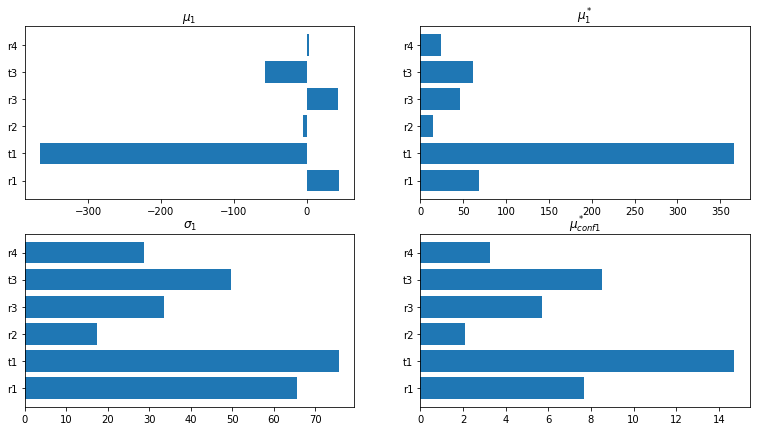

In [40]:
fig, ax = plt.subplots(2,2, figsize=(13,7))
ax[0,0].barh(Mi1['names'],Mi1['mu'])
ax[0,0].set_title('$\mu_1$')
ax[0,1].barh(Mi1['names'],Mi1['mu_star'])
ax[0,1].set_title('$\mu^*_1$')
ax[1,0].barh(Mi1['names'],Mi1['sigma'])
ax[1,0].set_title('$\sigma_1$')
ax[1,1].barh(Mi1['names'],Mi1['mu_star_conf'])
ax[1,1].set_title('$\mu^*_{conf 1}$');

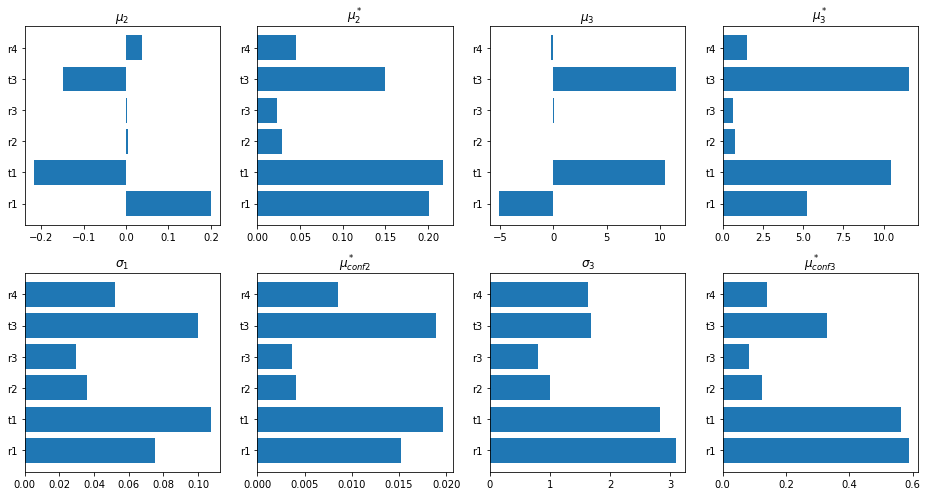

In [41]:
fig, ax = plt.subplots(2,4, figsize=(13,7))
ax[0,0].barh(Mi2['names'],Mi2['mu'])
ax[0,0].set_title('$\mu_2$')
ax[0,1].barh(Mi2['names'],Mi2['mu_star'])
ax[0,1].set_title('$\mu^*_2$')
ax[1,0].barh(Mi2['names'],Mi2['sigma'])
ax[1,0].set_title('$\sigma_1$')
ax[1,1].barh(Mi2['names'],Mi2['mu_star_conf'])
ax[1,1].set_title('$\mu^*_{conf 2}$')

ax[0,2].barh(Mi3['names'],Mi3['mu'])
ax[0,2].set_title('$\mu_3$')
ax[0,3].barh(Mi3['names'],Mi3['mu_star'])
ax[0,3].set_title('$\mu^*_3$')
ax[1,2].barh(Mi3['names'],Mi3['sigma'])
ax[1,2].set_title('$\sigma_3$')
ax[1,3].barh(Mi3['names'],Mi3['mu_star_conf'])
ax[1,3].set_title('$\mu^*_{conf 3}$');

plt.tight_layout();

 - ###### Conclusion:

Here, basically, we see the same. High $\mu^*$ depicts factor with high overall influence, we see that it's again first, second and fifth variable, while their high $\sigma$ detects either their interactions with other variables or non-linear effect on output. Anyway, both $\mu^*$ and $\sigma$ say that first, second and fifth features are the most influential, what coincides with conclusions we made in Sobol SA.

<br/> <!--Intentionally left blank-->

### Task 2.3 (4 pt.): Optimization

The final goal is to optimize the **mass** of the rotating disk. It will be done with scipy optimizer via approximation, provided by the surrogate model. We assume that surrogate model is of reasonable quality. The optimization problem for full parameter space is prepared for you.

The following optimization problem should be solved:

$$
{\rm mass} \rightarrow \min_x \\
\mbox{subject to} \quad S_{max}(x) \le 600 \\
\qquad \qquad U_2(x) \le 0.3
$$

Your tasks:

* Perform optimization by running the code below
* After performing sensitivity analysis you got the most influential features. Reestimate your models on the reduced feature space
* Change the optimization problem statement so that it usess only the selected variables
* Compare the optimal results for two formulations considered and make a conclusion

In [42]:
best_models = [model1, model2, model3]

In [46]:
result = minimize(lambda x: best_models[0].predict(x.reshape(1, -1)),
                  [109.0, 32.0, 123.0, 154.0, 6.0, 198.0],
                  bounds=problem['bounds'],
                  constraints=[{'type': 'ineq',
                                'fun' : lambda x: 600 - best_models[1].predict(x.reshape(1, -1))
                               },
                               {'type': 'ineq',
                                'fun' : lambda x: 0.3 - best_models[2].predict(x.reshape(1, -1))
                               }])
print(result)

     fun: 2281319.680499761
     jac: array([  45513.46875, -111982.75   ,   38772.25   ,    7540.5    ,
         -7740.09375,   -2517.28125])
 message: 'Inequality constraints incompatible'
    nfev: 8
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([ 109.,   32.,  123.,  154.,    6.,  198.])


 - After performing sensitivity analysis you got the most influential features. Reestimate your models on the reduced feature space:

In [ ]:
X_reduced = X[['r1','t1','t3']].copy()

In [47]:
model1= SVR(**{'C': 2.0, 'coef0': 2.0, 'degree': 3, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'}) #first target
model1.fit(X_reduced,t1)

model2= SVR(**{'C': 2.0, 'coef0': 2.0, 'degree': 3, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'}) #second target
model2.fit(X_reduced,t2)

model3= KernelRidge(**{'alpha': 0.5, 'coef0': 2.0, 'degree': 2, 'gamma': 7, 'kernel': 'poly'}) #third target
model3.fit(X_reduced,t3)

print('Model 1 reestimation on reduced feature space: ',cross_val_score(model1, X_reduced, t1).mean())
print('Model 2 reestimation on reduced feature space: ',cross_val_score(model2, X_reduced, t2).mean())
print('Model 3 reestimation on reduced feature space: ',cross_val_score(model3, X_reduced, t3).mean())

Model 1 reestimation on reduced feature space:  0.730796443208
Model 2 reestimation on reduced feature space:  0.954497828066
Model 3 reestimation on reduced feature space:  0.988671048291


 - Change the optimization problem statement so that it usess only the selected variables:

In [48]:
best_models = [model1, model2, model3]

problem_red = {
    'num_vars': 3,
    'names':['r1','t1','t3'],
    'bounds': np.array([[-1.7321, 1.7321],
                        [-1.7321, 1.7321],
                        [-1.7321, 1.7321]]),
    'groups': None
    }

In [49]:
result = minimize(lambda x: best_models[0].predict(x.reshape(1, -1)),
                  [109.0, 32.0, 123.0],
                  bounds=problem_red['bounds'],
                  constraints=[{'type': 'ineq',
                                'fun' : lambda x: 600 - best_models[1].predict(x.reshape(1, -1))
                               },
                               {'type': 'ineq',
                                'fun' : lambda x: 0.3 - best_models[2].predict(x.reshape(1, -1))
                               }])
print(result)

     fun: -5866553.26043456
     jac: array([-43608.4375, -23559.4375, -99255.4375])
 message: 'Inequality constraints incompatible'
    nfev: 5
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([ 109.,   32.,  123.])


- Compare the optimal results for two formulations considered and make a conclusion:

We see that, we that for variables of reduced feature space optimization in both cases gives approximately same results. These variables carry a lot of information. If we, for example, try to exclude the second variable but leave all others, our overall performance would not be so great. However, using first, second and fifth features, (in fact, we reduce our feature space by a half!) we achieve amazing performance, which is only slightly (0.5-1%) worse than the full feature space performance.